In [1]:
import os; os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
import seaborn as sns

from src.cell_class import Cell
from src import pltools

# Load data

In [3]:
DATA_PATH = os.path.join('data', 'raw')

In [4]:
# Short current step recordings.
short_fnames = {}
short_recs = {}
for cell_type in ['GABA']:
    short_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'current_steps', 'index.csv'))
    short_recs[cell_type] = Cell().read_ABF(
        [os.path.join(DATA_PATH, cell_type, 'current_steps', fname_) for fname_ in short_fnames[cell_type]['Steps']]
    )
    for sr in short_recs[cell_type]:
        sr.set_dt(0.1)

# Long current step recordings.
long_fnames = {}
long_recs = {}
for cell_type in ['5HT', 'GABA']:
    long_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'long_curr_steps', 'index.csv'))
    long_recs[cell_type] = Cell().read_ABF(
        [
            os.path.join(DATA_PATH, cell_type, 'long_curr_steps', fname_) 
            for fname_ in long_fnames[cell_type]['weak_steps']
            if isinstance(fname_, str)
        ]
    )
    for lr in long_recs[cell_type]:
        lr.set_dt(0.1)

In [5]:
short_fnames['GABA']

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


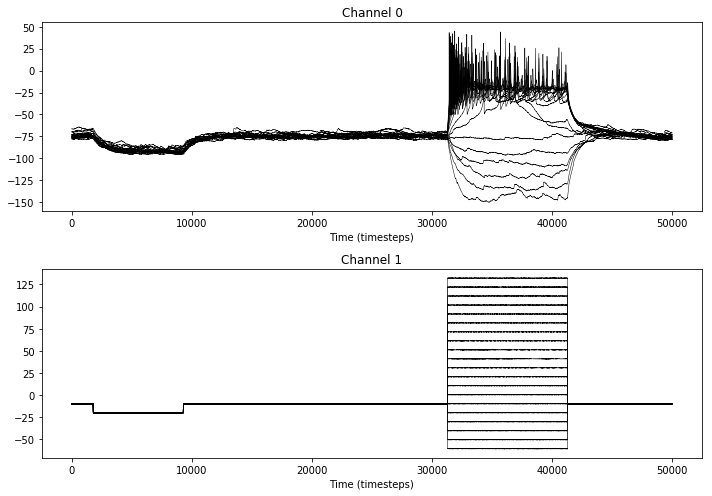

In [6]:
short_recs['GABA'][0].plot()

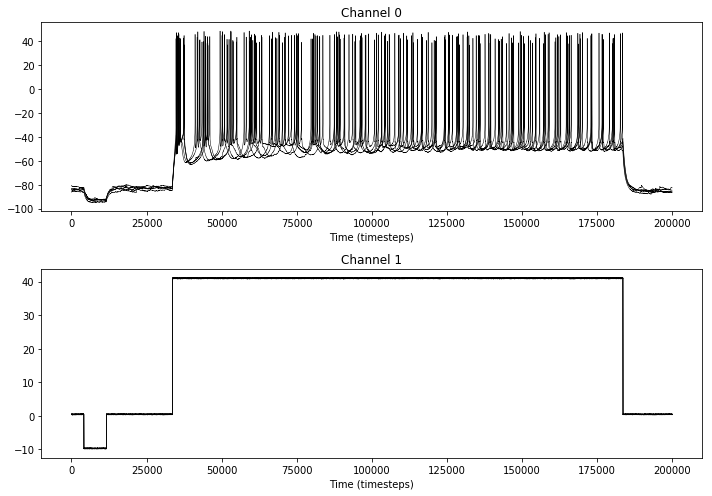

In [7]:
long_recs['5HT'][0].plot()

# Membrane parameters

Find test pulse range.

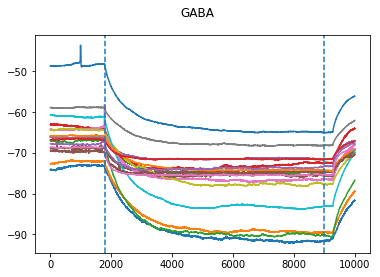

In [8]:
for cell_type in short_recs:
    plt.figure()
    plt.suptitle(cell_type)
    for i in range(len(short_recs[cell_type])):
        plt.plot(short_recs[cell_type][i].mean(axis=2)[0, :10000])
    plt.axvline(1800, ls='--')
    plt.axvline(9000, ls='--')
    plt.show()

Fit test pulse.

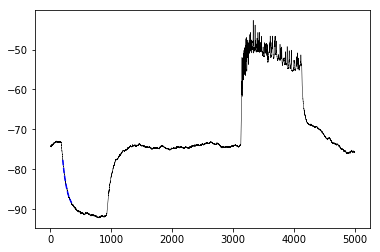



### Test-pulse results ###
R_in: 1793.2 +/- 390.0 MOhm


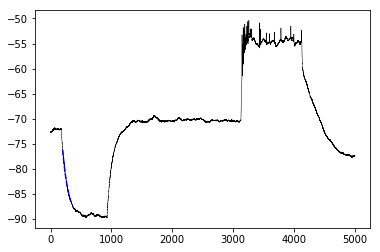



### Test-pulse results ###
R_in: 1702.5 +/- 241.0 MOhm


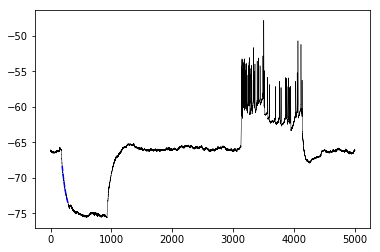



### Test-pulse results ###
R_in: 887.7 +/- 115.0 MOhm


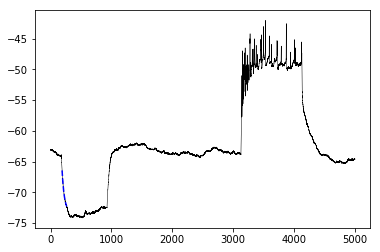



### Test-pulse results ###
R_in: 909.0 +/- 260.0 MOhm


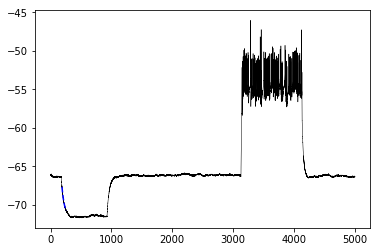



### Test-pulse results ###
R_in: 508.2 +/- 46.0 MOhm


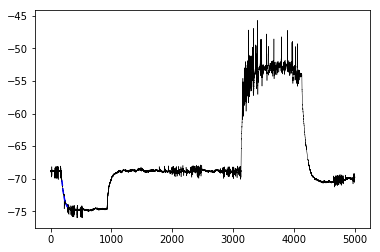



### Test-pulse results ###
R_in: 572.2 +/- 58.0 MOhm


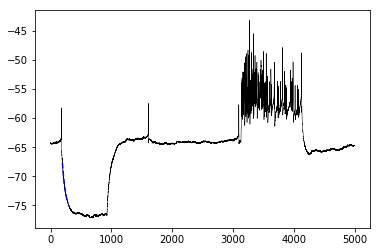



### Test-pulse results ###
R_in: 1209.8 +/- 85.0 MOhm


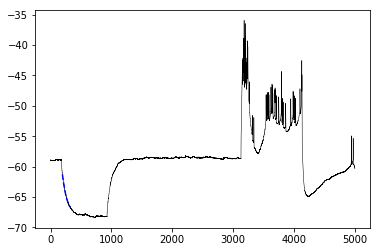



### Test-pulse results ###
R_in: 906.9 +/- 66.0 MOhm


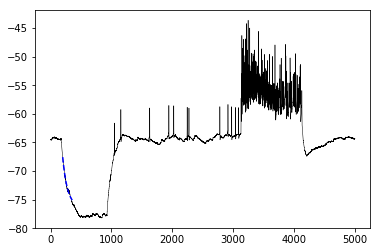



### Test-pulse results ###
R_in: 1335.8 +/- 209.0 MOhm


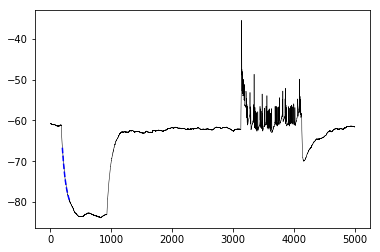



### Test-pulse results ###
R_in: 2216.5 +/- 415.0 MOhm


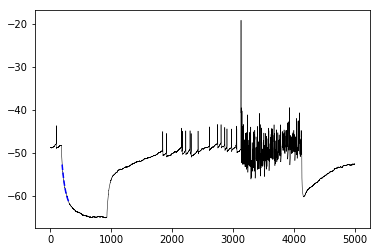



### Test-pulse results ###
R_in: 1620.8 +/- 384.0 MOhm


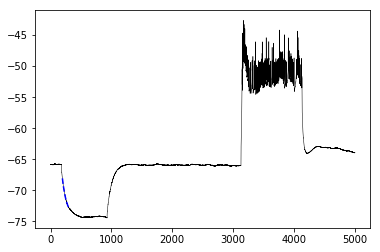



### Test-pulse results ###
R_in: 832.8 +/- 57.0 MOhm


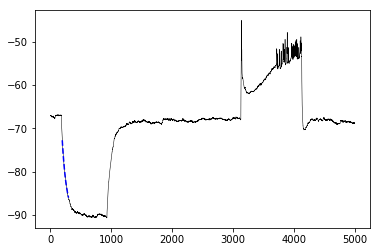



### Test-pulse results ###
R_in: 2251.9 +/- 260.0 MOhm


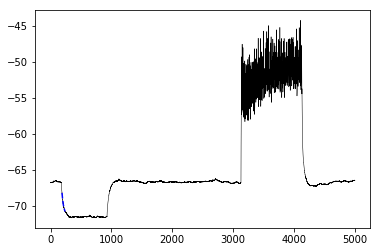



### Test-pulse results ###
R_in: 486.0 +/- 52.0 MOhm


src/cell_class.py:310: RuntimeWarning: divide by zero encountered in true_divide
  R_input = 1000 * delta_V_ss / delta_I_ss


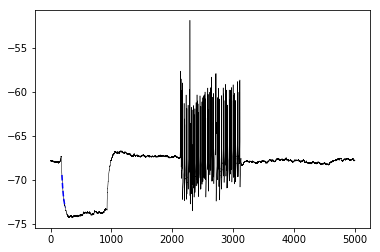



### Test-pulse results ###
R_in: -inf +/- nan MOhm


/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


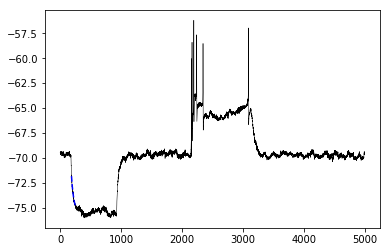



### Test-pulse results ###
R_in: -inf +/- nan MOhm


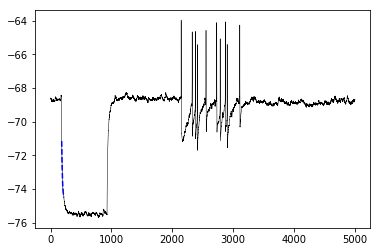



### Test-pulse results ###
R_in: 663.5 +/- 45.0 MOhm


In [9]:
def pctile_inds(arr, pctiles):
    """Find indices for percentiles.
    
    Example: indices for eighty twenty interval.
    
    """
    arr = arr.copy()
    data_percentiles = arr - arr.min()
    data_percentiles /= data_percentiles.max()
    output = []
    for pctile in pctiles:
        output.append(np.argmin(np.abs(data_percentiles - pctile)))
    return output

membrane_params = {}
for cell_type in short_recs:
    membrane_params[cell_type] = pd.DataFrame()
    for i in range(len(short_recs[cell_type])):
        short_recs[cell_type][i].set_dt(0.1)
        tau_limits = pctile_inds(short_recs[cell_type][i][0, 1800:9000, :].mean(axis=1), [.8, .2])
        tmp_params = short_recs[cell_type][i].fit_test_pulse(
            (0, 1000), 
            (8000, 9000), 
            tau=(1800, tau_limits[0] + 1800, tau_limits[1] + 1800),
            V_clamp=False,
            V_chan=0,
            I_chan=1,
            plot_tau=True
        )
        tmp_params['R_input'] = np.mean(tmp_params['R_input'])  # Average R_in across sweeps.
        membrane_params[cell_type] = membrane_params[cell_type].append(tmp_params, ignore_index=True)
    
    membrane_params[cell_type] = membrane_params[cell_type].astype(np.float64)

Extracted parameters. R_input is in MOhm and tau is in ms. Note that some recordings have non-finite R_in, probably due to missing current channel.

In [10]:
membrane_params['GABA']

,R_input,tau
0,1793.160321,78.830091
1,1702.543980,102.845330
2,887.729193,90.213577
3,909.036181,39.113562
4,508.195696,42.118490
5,572.233780,46.390837
6,1209.847907,56.203347
7,906.909309,81.395212
8,1335.769825,77.956294
9,2216.512496,68.124219


## Export membrane parameter plots

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


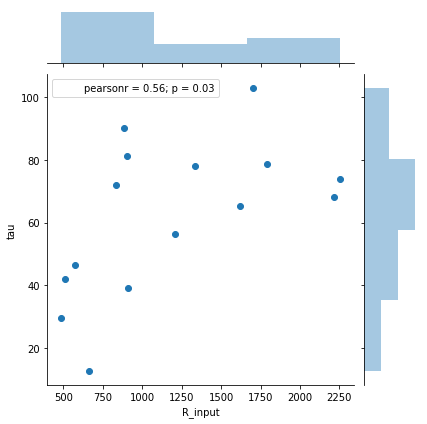

In [11]:
for cell_type in membrane_params:
    mask = np.isfinite(membrane_params[cell_type]['R_input'])
    
    sns.jointplot(membrane_params[cell_type]['R_input'][mask], membrane_params[cell_type]['tau'][mask])
    plt.savefig(os.path.join('figs', 'ims', 'writeup', 'fig1', '{}_membrane_params.png'.format(cell_type)), dpi=300)

# Long current steps

## Export traces
